# Hoja de Trabajo 2 - Entrega #2 del Proyecto
Diego Duarte 22075 - José Marchena 22398

### 1. Clustering

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

movies=pd.read_csv("movies.csv", encoding="ISO-8859-1")

In [4]:
import random
import pyclustertend 
import sklearn

movies['castWomenAmount'] = pd.to_numeric(movies['castWomenAmount'], errors='coerce')
movies['castMenAmount'] = pd.to_numeric(movies['castMenAmount'], errors='coerce')
movies['castWomenAmount'] = movies['castWomenAmount'].astype(float)
movies['castMenAmount'] = movies['castMenAmount'].astype(float)
movies = movies.dropna(subset=['castWomenAmount', 'castMenAmount'])
nmovies = movies.select_dtypes(include=[float, int])
nmovies.describe()

,id,budget,revenue,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount
count,9838.000000,9.838000e+03,9.838000e+03,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000,9838.000000
mean,244750.172088,1.883274e+07,5.762405e+07,100.939317,51.592854,6.491462,1364.069018,2.608457,3.127668,1.749034,27.678187,7.148201,16557.193434
std,254676.542333,3.681847e+07,1.506116e+08,26.803554,218.427093,0.958335,2579.594831,1.133813,2.257934,3.017306,22.700241,6.281767,100455.960117
min,5.000000,0.000000e+00,0.000000e+00,0.000000,4.258000,1.300000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,12139.250000,0.000000e+00,0.000000e+00,90.000000,14.551750,5.900000,128.000000,2.000000,2.000000,1.000000,13.000000,3.000000,7.000000
50%,137100.000000,9.050000e+05,3.291610e+05,100.000000,21.842000,6.500000,430.000000,3.000000,3.000000,1.000000,21.000000,6.000000,12.000000
75%,446305.250000,2.100000e+07,4.619692e+07,113.000000,40.640500,7.200000,1345.750000,3.000000,4.000000,2.000000,36.000000,9.000000,20.000000
max,922260.000000,3.800000e+08,2.847246e+09,750.000000,11474.647000,10.000000,30788.000000,8.000000,26.000000,155.000000,313.000000,106.000000,922017.000000


In [5]:
# Quitando 0s porque se sabe que todos los campos son positivos mayores a 0
n_cols = nmovies.columns
nmovies = nmovies.dropna(axis=0)
nfmovies = nmovies[(nmovies > 0).all(axis=1)]

In [6]:
# Eliminación de atípicos con IQR
Q1 = nmovies.quantile(0.25)  # 25th percentile
Q3 = nmovies.quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Filter out outliers
new_movies = nfmovies[~((nfmovies < (Q1 - 1.5 * IQR)) | (nfmovies > (Q3 + 1.5 * IQR))).any(axis=1)]

In [7]:
# Estdaística de hopkins para medir la pertinencia de aplicar clusters
random.seed(123)
X_scale = sklearn.preprocessing.scale(new_movies[['budget','revenue', 'voteAvg','popularity','actorsAmount','voteCount','genresAmount','productionCoAmount']])
hopkins_stat = pyclustertend.hopkins(X_scale, len(X_scale))
print(f'Estadística de Hopkins: {hopkins_stat}')

Estadística de Hopkins: 0.3555995541393774


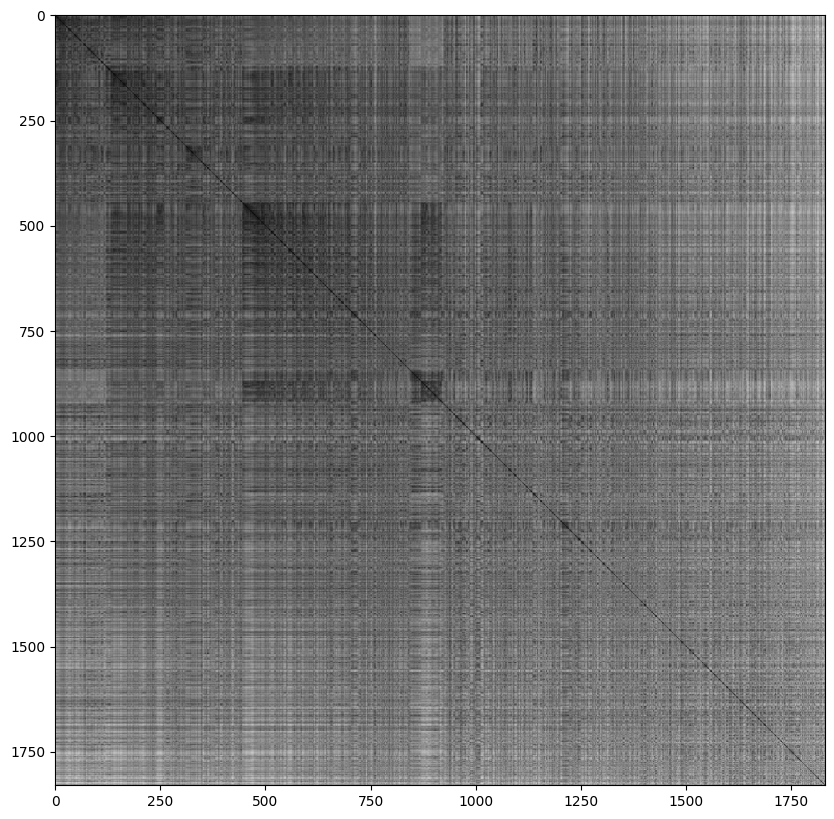

In [8]:
pyclustertend.vat(X_scale)

### 2. Reglas de Asociación 

In [9]:
from apyori import apriori
from sklearn.compose import make_column_selector 
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer 
from sklearn.compose import ColumnTransformer

In [10]:
movies['revenue_amount'] = "Nulo Revenue"

movies.loc[movies['revenue'] > 0, 'revenue_amount'] = pd.qcut(
    movies[movies['revenue'] > 0]['revenue'],
    q=4,
    labels=["Bajo Revenue", "Medio-Bajo Revenue", "Medio-Alto Revenue", "Alto Revenue"],
    duplicates="drop"
)

movies['budget_amount'] = "Nulo Budget"

movies.loc[movies['budget'] > 0, 'budget_amount'] = pd.qcut(
    movies[movies['budget'] > 0]['budget'],
    q=4,
    labels=["Bajo Budget", "Medio-Bajo Budget", "Medio-Alto Budget", "Alto Budget"],
    duplicates="drop"
)

movies["main_genre"] = movies["genres"].str.split("|").str[0]

def clean_and_average(x):
    if isinstance(x, str):
        values = x.split('|')
        numeric_values = []
        for v in values:
            try:
                numeric_values.append(float(v))
            except ValueError:
                continue
        if numeric_values:
            return sum(numeric_values) / len(numeric_values)
    return 0

# Aplicar la limpieza y el cálculo del promedio
movies['actors_popularity_avg'] = movies['actorsPopularity'].apply(clean_and_average)

labelsPopActors = ["Poca en Actores", "Relativamente Pocae en Actores", "Relativamente Mucha en Actores", "Mucha en Actores"]
labelsPopMovie = ["Poca en Pelicula", "Relativamente Poca en Pelicula", "Relativamente Mucha en Pelicula", "Mucha en Pelicula"]
labelsVotos = ["Pocos Votos", "Relativamente Pocos Votos", "Relativamente Muchos Votos", "Muchos Votos"]
labelsVotosAvg = ["Bajo Promiedo Votos", "Medio-Bajo Promiedo Votos", "Medio-Alto Promiedo Votos", "Alto Promiedo Votos"]

movies['popularity_avg_actors'] = pd.qcut(movies['actors_popularity_avg'], q=4, labels=labelsPopActors)
movies['popularity_movies'] = pd.qcut(movies['popularity'], q=4, labels=labelsPopMovie)
movies['cant_votos'] = pd.qcut(movies['voteCount'], q=4, labels=labelsVotos)
movies['avg_votos'] = pd.qcut(movies['voteAvg'], q=4, labels=labelsVotosAvg)

movies["release_date"] = pd.to_datetime(movies["releaseDate"], errors='coerce')

movies["release_decade"] = (movies["release_date"].dt.year // 10) * 10

#print(movies['revenue_amount'].value_counts())
#print(movies['budget_amount'].value_counts())
#print(movies["main_genre"].value_counts())
#print(movies['popularity_avg_actors'].value_counts())
#print(movies['popularity_movies'].value_counts())
#print(movies['cant_votos'].value_counts())
#print(movies['avg_votos'].value_counts())
#print(movies['originalLanguage'].value_counts())
#print(movies['release_decade'].value_counts())

categoricas = movies[['revenue_amount','budget_amount',"main_genre",'popularity_avg_actors','popularity_movies','cant_votos','avg_votos', 'originalLanguage', 'release_decade']]
print(categoricas.shape)




(9838, 9)


In [11]:
records = []

for i in range(0, 9832):
    records.append([str(categoricas.values[i,j]) for j in range(0, 9)]) 
records

[['Bajo Revenue',
  'Bajo Budget',
  'Crime',
  'Mucha en Actores',
  'Relativamente Poca en Pelicula',
  'Muchos Votos',
  'Bajo Promiedo Votos',
  'en',
  '1990'],
 ['Medio-Bajo Revenue',
  'Medio-Alto Budget',
  'Action',
  'Relativamente Mucha en Actores',
  'Poca en Pelicula',
  'Relativamente Pocos Votos',
  'Medio-Bajo Promiedo Votos',
  'en',
  '1990'],
 ['Alto Revenue',
  'Medio-Bajo Budget',
  'Adventure',
  'Poca en Actores',
  'Mucha en Pelicula',
  'Muchos Votos',
  'Alto Promiedo Votos',
  'en',
  '1970'],
 ['Alto Revenue',
  'Alto Budget',
  'Animation',
  'Mucha en Actores',
  'Mucha en Pelicula',
  'Muchos Votos',
  'Alto Promiedo Votos',
  'en',
  '2000'],
 ['Alto Revenue',
  'Alto Budget',
  'Comedy',
  'Relativamente Pocae en Actores',
  'Mucha en Pelicula',
  'Muchos Votos',
  'Alto Promiedo Votos',
  'en',
  '1990'],
 ['Alto Revenue',
  'Medio-Bajo Budget',
  'Drama',
  'Relativamente Pocae en Actores',
  'Relativamente Mucha en Pelicula',
  'Muchos Votos',
  'Alt

In [12]:
reglas_asociacion1 = apriori(records,min_support=0.3, min_confidence = 0.7)
reglas1 = list(reglas_asociacion1)
print(len(reglas1))

reglas_asociacion2 = apriori(records,min_support=0.1, min_confidence = 0.6)
reglas2 = list(reglas_asociacion2)
print(len(reglas2))

reglas_asociacion3 = apriori(records,min_support=0.2, min_confidence = 0.8)
reglas3 = list(reglas_asociacion3)
print(len(reglas3))

3
66
12


In [13]:
def inspect(output):
    records = []
    for result in output:
        support = result.support
        for ordered_stat in result.ordered_statistics:
            lhs = ', '.join(ordered_stat.items_base) if ordered_stat.items_base else '∅'
            rhs = ', '.join(ordered_stat.items_add)
            confidence = ordered_stat.confidence
            lift = ordered_stat.lift
            records.append((lhs, rhs, support, confidence, lift))
    
    return records

In [14]:
output_DataFrame = pd.DataFrame(inspect(reglas1), columns=['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
print(output_DataFrame)

  Left_Hand_Side Right_Hand_Side   Support  Confidence      Lift
0              ∅              en  0.779496    0.779496  1.000000
1           2010              en  0.356489    0.759151  0.973900
2    Nulo Budget    Nulo Revenue  0.386290    0.815546  1.737476
3   Nulo Revenue     Nulo Budget  0.386290    0.822969  1.737476


In [15]:
output_DataFrame = pd.DataFrame(inspect(reglas2), columns=['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
print(output_DataFrame)

                                  Left_Hand_Side            Right_Hand_Side  \
0                                              ∅                         en   
1                                           2000                         en   
2                                           2010                         en   
3                                           2020                Nulo Budget   
4                                           2020               Nulo Revenue   
5                                         Action                         en   
6                                    Alto Budget                         en   
7                            Alto Promiedo Votos                         en   
8                                   Alto Revenue               Muchos Votos   
9                                   Alto Revenue                         en   
10                                   Bajo Budget                         en   
11                           Bajo Promiedo Votos    

In [16]:
output_DataFrame = pd.DataFrame(inspect(reglas3), columns=['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
print(output_DataFrame)

                    Left_Hand_Side            Right_Hand_Side   Support  \
0              Bajo Promiedo Votos                         en  0.224675   
1        Medio-Bajo Promiedo Votos                         en  0.204231   
2                 Mucha en Actores                         en  0.221928   
3                     Muchos Votos                         en  0.236168   
4                      Nulo Budget               Nulo Revenue  0.386290   
5                     Nulo Revenue                Nulo Budget  0.386290   
6                      Pocos Votos                Nulo Budget  0.215419   
7                      Pocos Votos               Nulo Revenue  0.223963   
8   Relativamente Mucha en Actores                         en  0.206876   
9       Relativamente Muchos Votos                         en  0.211554   
10               2010, Nulo Budget               Nulo Revenue  0.201790   
11              2010, Nulo Revenue                Nulo Budget  0.201790   
12                     Po

### 3. Análisis de Componentes Principales 

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movies["has_homepage"] = movies["homePage"].notna().astype(int)
#movies['actors_popularity_avg']) average popularity
movies['castWomenAmount'] = pd.to_numeric(movies['castWomenAmount'], errors='coerce')
movies['castMenAmount'] = pd.to_numeric(movies['castMenAmount'], errors='coerce')
movies['castWomenAmount'] = movies['castWomenAmount'].astype(float)
movies['castMenAmount'] = movies['castMenAmount'].astype(float)
movies = movies.dropna(subset=['castWomenAmount', 'castMenAmount'])


cuantitativos = movies.select_dtypes(include=['int64', 'float64', 'int32']).drop(columns=["id"])
print(cuantitativos.head())




     budget      revenue  runtime  popularity  voteAvg  voteCount  \
0   4000000    4257354.0       98      20.880      5.7       2077   
1  21000000   12136938.0      110       9.596      6.5        223   
2  11000000  775398007.0      121     100.003      8.2      16598   
3  94000000  940335536.0      100     134.435      7.8      15928   
4  55000000  677387716.0      142      58.751      8.5      22045   

   genresAmount  productionCoAmount  productionCountriesAmount  actorsAmount  \
0             2                   2                          1            25   
1             3                   3                          2            15   
2             3                   2                          1           105   
3             2                   1                          1            24   
4             3                   2                          1            76   

   castWomenAmount  castMenAmount  actors_popularity_avg  release_decade  \
0             15.0          

In [22]:
chi_cuadrado, p_valor = calculate_bartlett_sphericity(cuantitativos)
print(f'Valor Chi-cuadrado: {chi_cuadrado}')
print(f'Valor p: {p_valor}')

if (p_valor < 0.05):
    print("Hay correlacion entre las variables, recomedable usar PCA")
else:
    print("No hay correlacion entre las variables, no recomedable usar PCA")

Valor Chi-cuadrado: 39083.141220450874
Valor p: 0.0
Hay correlacion entre las variables, recomedable usar PCA


In [23]:
kmo, kmo_modelo = calculate_kmo(cuantitativos)
print(f'Índice KMO: {kmo_modelo:.4f}')

if kmo_modelo < 0.5:
    print("No hay correlación entre las variables, no usar PCA")
elif 0.5 <= kmo_modelo < 0.6:
    print("Pobre correlación entre las variables, no recomendable usar PCA")
elif 0.6 <= kmo_modelo < 0.7:
    print("Correlación regular entre las variables, revisa antes de usar PCA")
elif 0.7 <= kmo_modelo < 0.8:
    print("Correlación aceptable entre las variables, PCA no va a ser perfecto")
elif 0.8 <= kmo_modelo < 0.9:
    print("Muy buena correlación entre las variables, recomendable usar PCA")
else:  # Esto cubre el rango 0.9 - 1.0
    print("Hay correlación excelente entre las variables, perfecto para PCA")


Índice KMO: 0.6929
Correlación regular entre las variables, revisa antes de usar PCA


In [25]:
pca_pipe = make_pipeline(StandardScaler(),PCA()) #Se escalan los datos y luego se le aplica PCA
pca_pipe.fit(cuantitativos)

#Se extrae el modelo del pipeline
modelo_pca = pca_pipe.named_steps['pca']
print(f'Cantidad de Componentes Generados: {len(modelo_pca.components_)}')


#Se convierte el arreglo en data frame
print("Resultado del PCA:")
pd.DataFrame(
    data = modelo_pca.components_,
    columns = cuantitativos.columns,
    index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15']
)

Cantidad de Componentes Generados: 15
Resultado del PCA:


,budget,revenue,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,actors_popularity_avg,release_decade,has_homepage
PC1,0.423717,0.432297,0.272949,0.098051,0.149915,0.434692,0.113132,0.139538,-0.052753,0.395418,0.314165,-0.120289,0.040569,-0.050100,0.171181
PC2,0.185901,0.172151,-0.199088,0.258939,-0.141550,0.104273,0.025296,0.045611,0.312662,-0.257097,-0.107149,0.371505,0.345681,0.522965,0.298578
PC3,-0.061173,-0.016776,0.153153,-0.111225,0.040976,0.005193,-0.290132,-0.112653,0.573331,0.199142,0.269266,0.528500,-0.346323,-0.101212,-0.105880
PC4,-0.154775,-0.255758,0.079706,-0.098470,-0.252599,-0.206795,-0.222542,0.443729,-0.072271,0.245245,0.323492,-0.200964,-0.149809,0.445412,0.332198
PC5,-0.216005,-0.163739,0.310340,0.096545,0.728609,-0.005261,0.077318,0.288049,0.119093,-0.153679,-0.229448,0.033848,-0.034996,-0.011959,0.328770
PC6,0.075222,-0.078923,0.150875,-0.400731,-0.180649,-0.091939,0.496393,0.481581,0.322748,-0.040954,0.021106,0.045478,0.305552,-0.140082,-0.252998
PC7,-0.037611,-0.133082,0.199888,0.813968,-0.076979,-0.199758,0.019583,0.168926,0.088640,0.071991,0.133057,-0.055670,0.101150,-0.058498,-0.395134
PC8,-0.078496,-0.105169,-0.330295,0.163422,0.045781,-0.124836,0.725185,-0.205215,0.063978,0.164697,0.215977,0.046637,-0.357379,0.035507,0.228625
PC9,-0.183866,-0.202996,0.089029,-0.093805,0.175500,-0.116887,-0.020521,-0.440413,0.057055,0.102356,0.449539,-0.069606,0.654752,-0.031160,0.138127
PC10,0.101163,-0.035515,0.685543,0.032145,-0.409584,-0.170023,0.154800,-0.329213,-0.007708,-0.076570,-0.245561,0.020677,-0.097335,-0.057214,0.330294


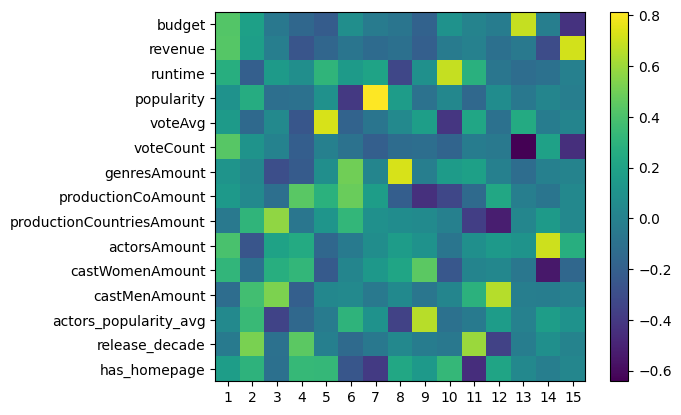

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)
componentes = modelo_pca.components_
plt.imshow(componentes.T)
plt.yticks(range(len(cuantitativos.columns)), cuantitativos.columns)
plt.xticks(range(len(cuantitativos.columns)), np.arange(modelo_pca.n_components_)+1)
plt.grid(False)
plt.colorbar()

In [27]:
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.23458163 0.10465399 0.0956634  0.08332231 0.07257409 0.06798477
 0.06117291 0.05986516 0.05549125 0.04377064 0.03876341 0.03409548
 0.02097132 0.01538139 0.01170824]


Text(0, 0.5, 'Por. varianza explicada')

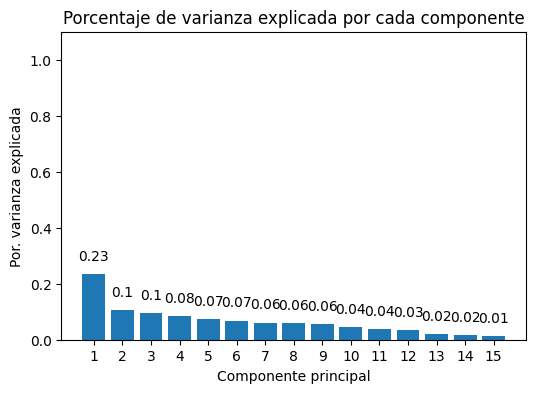

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(cuantitativos.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.23458163 0.33923562 0.43489902 0.51822133 0.59079542 0.65878019
 0.71995311 0.77981827 0.83530952 0.87908016 0.91784358 0.95193905
 0.97291037 0.98829176 1.        ]


Text(0, 0.5, 'Por. varianza acumulada')

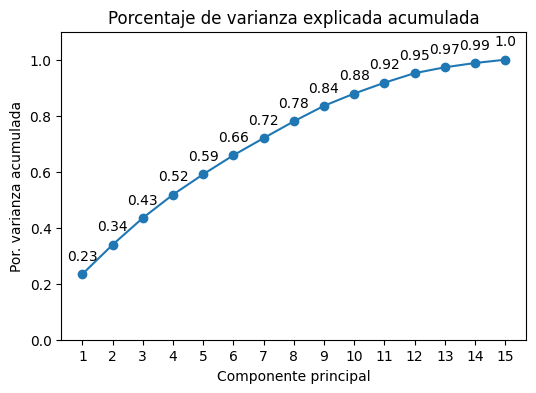

In [29]:
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(cuantitativos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(cuantitativos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

In [32]:
cargas = modelo_pca.components_[:9]

# Imprimir las cargas para interpretación
for i, carga in enumerate(cargas):
    print(f'Componente {i+1}:')
    for j, variable in enumerate(cuantitativos.columns):
        print(f'  {variable}: {carga[j]:.3f}')
    print('---')

Componente 1:
  budget: 0.424
  revenue: 0.432
  runtime: 0.273
  popularity: 0.098
  voteAvg: 0.150
  voteCount: 0.435
  genresAmount: 0.113
  productionCoAmount: 0.140
  productionCountriesAmount: -0.053
  actorsAmount: 0.395
  castWomenAmount: 0.314
  castMenAmount: -0.120
  actors_popularity_avg: 0.041
  release_decade: -0.050
  has_homepage: 0.171
---
Componente 2:
  budget: 0.186
  revenue: 0.172
  runtime: -0.199
  popularity: 0.259
  voteAvg: -0.142
  voteCount: 0.104
  genresAmount: 0.025
  productionCoAmount: 0.046
  productionCountriesAmount: 0.313
  actorsAmount: -0.257
  castWomenAmount: -0.107
  castMenAmount: 0.372
  actors_popularity_avg: 0.346
  release_decade: 0.523
  has_homepage: 0.299
---
Componente 3:
  budget: -0.061
  revenue: -0.017
  runtime: 0.153
  popularity: -0.111
  voteAvg: 0.041
  voteCount: 0.005
  genresAmount: -0.290
  productionCoAmount: -0.113
  productionCountriesAmount: 0.573
  actorsAmount: 0.199
  castWomenAmount: 0.269
  castMenAmount: 0.529
 

In [33]:
X_reducido = modelo_pca.transform(cuantitativos)

print(X_reducido)

[[ 3.53615713e+06  1.47775561e+06 -3.16278267e+05 ...  2.51743587e+06
  -1.37286853e+06  1.31561641e+06]
 [ 1.41448570e+07  5.99436094e+06 -1.48840685e+06 ...  1.37552246e+07
  -4.09236163e+06 -3.59867153e+05]
 [ 3.39870288e+08  1.35533177e+08 -1.36806950e+07 ... -3.28301452e+07
  -2.36893913e+08  5.47288295e+08]
 ...
 [-2.16925186e+01  1.16329179e+03 -2.42021087e+02 ... -8.73618535e+01
   1.70225493e+02  8.69057728e+00]
 [-1.10909793e+05  3.43721804e+05  4.87045868e+05 ... -1.73198739e+04
  -2.47242744e+04 -3.04260180e+03]
 [ 2.17383311e+05  9.20415164e+04 -2.00145372e+04 ...  1.60781025e+05
  -8.20667436e+04  7.19875935e+04]]


c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
